In [174]:
"""
write a code that read the png files
"""
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as func
from tqdm.notebook import tqdm
from scipy.ndimage import maximum_filter
from scipy.ndimage import gaussian_filter


from PIL import Image
import glob



In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [231]:
data_train = {}
data_valid = {}
train_valid_split = 0.5

"""
The imagines with name 01 at last are the ones with the noise
those we will use to train the model
"""
for data in glob.glob('testdata/*'):
    if '01.png' not in data:
        continue
    img = Image.open(data)
    img = np.array(img)
    if np.random.rand() < train_valid_split:
        data_train[data] = img
    else:
        data_valid[data] = img

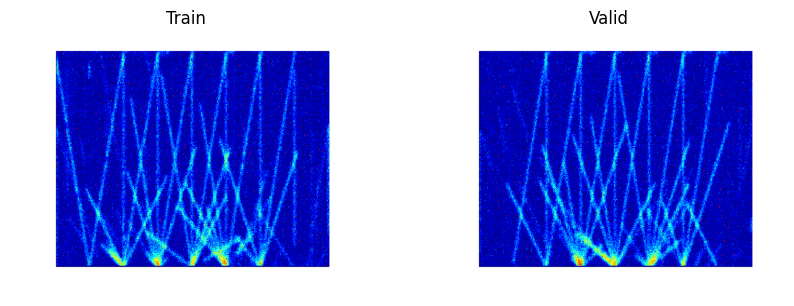

" \nFind the type of the each entry's data type\n"

In [232]:
"""
Show the images
"""
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(data_train[list(data_train.keys())[0]])
ax[0].set_title('Train')
ax[0].axis('off')
ax[1].imshow(data_valid[list(data_valid.keys())[0]])
ax[1].set_title('Valid')
ax[1].axis('off')
plt.show()

""" 
Find the type of the each entry's data type
"""




In [233]:
"""
get the shape of the data
"""
for key, value in data_train.items():
    print(key, value.shape)
    break

"""
rename the keys to be able to use the DataLoader
"""
# data_train = {i: v for i, v in enumerate(data_train.values())}
# for key, value in data_train.items():
#     print(key, value.shape)
#     break


testdata/run_004_image_01.png (875, 1167, 3)


'\nrename the keys to be able to use the DataLoader\n'

In [234]:
"""
crop the white background of each image, there are three channels
"""
def crop_background(img):
    mask = img.sum(axis=-1) != 255 * 3
    rows = np.where(mask.any(axis=1))[0]
    cols = np.where(mask.any(axis=0))[0]
    img = img[rows.min(): rows.max() + 1, cols.min(): cols.max() + 1]
    img = img.mean(axis=-1)
    return img

testdata/run_004_image_01.png (713, 904)
testdata/run_003_image_01.png (713, 904)


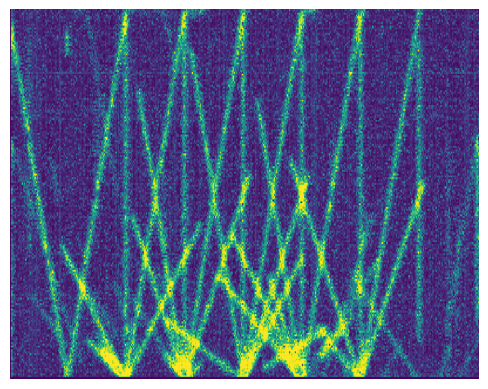

In [235]:

data_train = {k: crop_background(v) for k, v in data_train.items()}
data_valid = {k: crop_background(v) for k, v in data_valid.items()}

""" 
show one train image
"""
plt.imshow(data_train[list(data_train.keys())[0]])
plt.axis('off')

"""
get the shape of the data
"""
for key, value in data_train.items():
    print(key, value.shape)
    break

"""
get the shape of the validation data, it should be the same
"""
for key, value in data_valid.items():
    print(key, value.shape)
    break


(-0.5, 903.5, 712.5, -0.5)

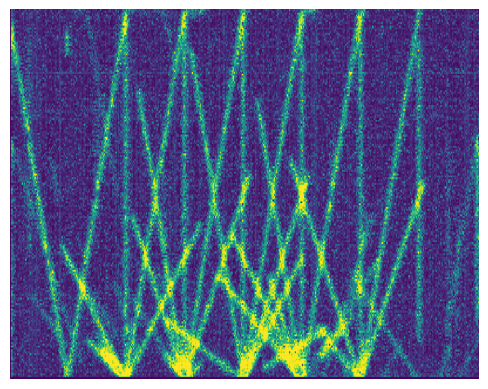

In [236]:
""" 
smooth the image 
"""
def smooth_image(img, sigma=1):
    return gaussian_filter(img, sigma=sigma)

""" 
sharpen the image 
"""
def sharpen_image(img, sigma=3):
    return img + (img - gaussian_filter(img, sigma=sigma))

""" 
increase the contrast of the image
"""
def contrast_image(img, alpha=100):
    return np.clip(alpha * img, 0, 255)

data_train = {k: contrast_image(v,1) for k, v in data_train.items()}
data_valid = {k: contrast_image(v,1) for k, v in data_valid.items()}

"""
show the image
"""
plt.imshow(data_train[list(data_train.keys())[0]])
plt.axis('off')


In [237]:
"""
we want to detect the key points of the image using Harris corner 
detection, which are the startings of the lines
"""
def harris_corner_detection(img, window_size=2, k=0.04):
    img = img.astype(np.float32)
    # smooth the image with a Gaussian kernel
    img = sharpen_image(img, 1)
    dx = np.array([[1, 0., -1]], dtype=np.float32)    
    dy = dx.T
    # dx, dy apply to an image to calculate the gradient of intensity

    Ix = func.conv2d(torch.tensor(img).unsqueeze(0).unsqueeze(0), torch.tensor(dx).unsqueeze(0).unsqueeze(0), padding='same')
    Iy = func.conv2d(torch.tensor(img).unsqueeze(0).unsqueeze(0), torch.tensor(dy).unsqueeze(0).unsqueeze(0), padding='same')
    # Ix, Iy are the gradient of intensity in x and y direction
    # torch.tensor(dx).unsqueeze(0).unsqueeze(0) is the kernel to calculate the gradient
    # squeeze(0) is to add a dimension to the tensor, so that it can be used in the conv2d function, whose input is 4D tensor (batch_size, channel, height, width)
    
    Ix = Ix.squeeze().numpy()
    Iy = Iy.squeeze().numpy()
    # convert the tensor to numpy array

    Ixx = Ix ** 2
    Iyy = Iy ** 2
    Ixy = Ix * Iy
    # Ixx, Iyy, Ixy are the elements of the structure tensor
    kernel = torch.ones((1, 1, window_size, window_size), dtype=torch.float32)  # Create a 4D kernel

    Sxx = func.conv2d(torch.tensor(Ixx).unsqueeze(0).unsqueeze(0), kernel, padding='same')
    Syy = func.conv2d(torch.tensor(Iyy).unsqueeze(0).unsqueeze(0), kernel, padding='same')
    Sxy = func.conv2d(torch.tensor(Ixy).unsqueeze(0).unsqueeze(0), kernel, padding='same')
    # Sxx, Syy, Sxy are the smoothed elements of the structure tensor
    
    # elminiates the batch and channel dimensions
    Sxx = Sxx.squeeze().numpy()
    Syy = Syy.squeeze().numpy()
    Sxy = Sxy.squeeze().numpy()
    # convert the tensor to numpy array

    det = Sxx * Syy - Sxy ** 2
    trace = Sxx + Syy
    R = det - k * trace ** 2
    # R is the Harris corner response
    """
    Now we have the Harris corner response
    we can find the key points by finding the local maximum of R
    """
    
    key_points = []
    # Assuming R is the input array and window_size is defined
    window_shape = (window_size, window_size)
    local_maxima = maximum_filter(R, size=window_shape, mode='constant', cval=0)

    # Identifying key points where the original array matches the local maxima
    key_points_mask = (R == local_maxima)
    # highlight the coordinates of the key points
    key_points = np.argwhere(key_points_mask)

    """
    Match the location of the key points to the original image
    """
    key_points = key_points + window_size // 2

    return key_points



(-0.5, 949.225, 748.675, -0.5)

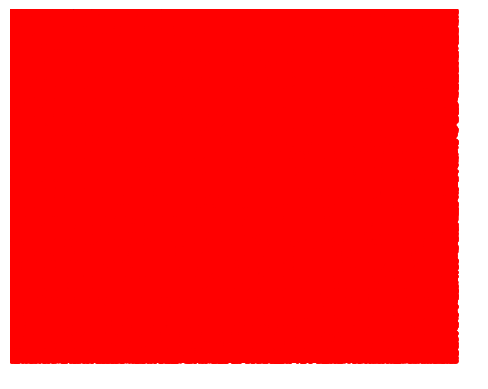

In [203]:
"""
Test the Harris corner detection using one image
"""
img = data_train[list(data_train.keys())[0]]
key_points = harris_corner_detection(img)
plt.imshow(img)
plt.scatter(key_points[:, 1], key_points[:, 0], c='r', s=5)
plt.axis('off')
